In [1]:
import cv2 as cv
import numpy as np
import os
import matplotlib.pyplot as plt
import random as rd

In [2]:
rd.seed(None)
dataset_dir = 'dataset'
background_dirt = 0.25 # 1=black background, 0=clear
foreground_dirt = 0.1 # 1=white foreground, 0=clear
edge_padding = 20 # px
warp_factor = 0.4
rotation_range = 60 # deg
trim_step = 30 # px, trim whitespace off a side in multiples of this
post_edge_padding = 0 # px
trim_before_warp = False
downscale_interpolation = cv.INTER_AREA # INTER_LINEAR, INTER_AREA
img_size = (10,14) # (28,40) (24,34) (20,29) (16,23) (12,19) (10,14)

def process_char(file):
    img_orig = cv.imread(os.path.join(dataset_dir, file), cv.IMREAD_UNCHANGED)
    
    # create background, make grayscale, apply random dirt
    bgcol = 1 - background_dirt * rd.random()
    fgcol = foreground_dirt * rd.random()
    img = np.ones((img_orig.shape[0],img_orig.shape[1])) * bgcol
    img[img_orig[:,:,3] != 0] = fgcol
    img = np.pad(img, edge_padding, constant_values=bgcol)

    # apply random rotation by img center
    # pad to prevent going out of shape range. This should work every time
    pad_x = int(np.sum(np.square(img.shape))**(1/2)-img.shape[1])//2
    pad_y = int(np.sum(np.square(img.shape))**(1/2)-img.shape[0])//2
    img = np.pad(img, ((pad_y, pad_y), (pad_x, pad_x)), constant_values=bgcol)
    matrix = cv.getRotationMatrix2D((img.shape[1]//2, img.shape[0]//2), (rd.random()-0.5)*rotation_range, 1)
    rotated = cv.warpAffine(img, matrix, (img.shape[1],img.shape[0]), borderValue=bgcol)
    
    img = rotated

    if trim_before_warp:
        # trim additional whitespaces
        while not any(img[:,2*trim_step]==fgcol):
            img = img[:,trim_step:]
        while not any(img[:,-2*trim_step]==fgcol):
            img = img[:,:-trim_step]
        while not any(img[2*trim_step,:]==fgcol):
            img = img[trim_step:,:]
        while not any(img[-2*trim_step,:]==fgcol):
            img = img[:-trim_step,:]

    # apply random warp
    while True:
        # get proportional warp ranges
        offset_x, offset_y = int(img.shape[1] * warp_factor)//2, int(img.shape[0] * warp_factor)//2
        points_start = np.float32([[0,0], [0, img.shape[0]], [img.shape[1], img.shape[0]], [img.shape[1], 0]])
        # pad around to prevent warping out of shape range
        # warp function's result shape doesn't expand to top and left
        warped = np.pad(img, ((offset_y,offset_y),(offset_x,offset_x)), constant_values=bgcol)
        # offset to actual character area for the warp function
        points_start[:,0] += offset_x
        points_start[:,1] += offset_y
        points_end = np.copy(points_start)
        points_end[:,0] = [i + (rd.random()-0.5) * offset_x for i in points_end[:,0]]
        points_end[:,1] = [i + (rd.random()-0.5) * offset_y for i in points_end[:,1]]
        matrix = cv.getPerspectiveTransform(points_start, points_end)
        result_shape = (warped.shape[1],warped.shape[0])
        warped = cv.warpPerspective(img, matrix, result_shape, borderValue=bgcol)
        # check borders intersecting with character, warp valid if none
        if all(warped[:,0]!=fgcol) and all(warped[:,-1]!=fgcol) and all(warped[0,:]!=fgcol) and all(warped[-1,:]!=fgcol):
            break
    
    img = warped
    
    # trim additional whitespaces
    while not any(img[:,2*trim_step]==fgcol):
        img = img[:,trim_step:]
    while not any(img[:,-2*trim_step]==fgcol):
        img = img[:,:-trim_step]
    while not any(img[2*trim_step,:]==fgcol):
        img = img[trim_step:,:]
    while not any(img[-2*trim_step,:]==fgcol):
        img = img[:-trim_step,:]

    img = np.pad(img, post_edge_padding, constant_values=bgcol)
    img = cv.resize(img, img_size, interpolation=downscale_interpolation)

    return (img, file[0])

def process_all_chars():
    chars_processed = []
    for file in os.listdir(dataset_dir):
        chars_processed.append(process_char(file))
        
    return chars_processed


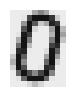

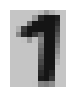

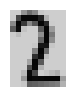

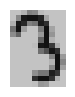

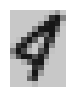

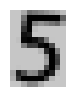

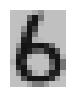

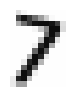

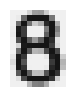

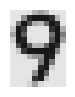

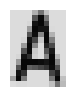

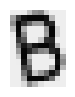

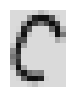

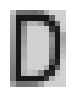

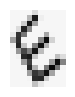

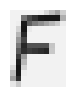

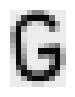

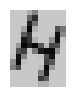

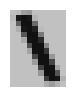

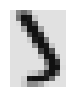

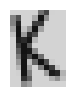

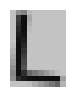

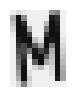

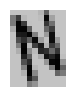

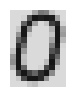

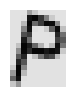

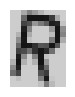

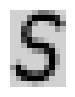

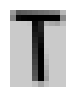

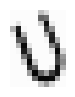

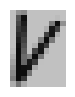

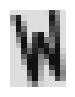

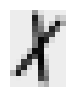

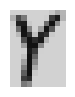

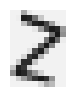

In [3]:
if True:
    for i in process_all_chars():
        plt.figure('a', figsize=(1,1))
        plt.axis('off')
        plt.imshow(i[0], cmap='gray', vmin=0, vmax=1)
        plt.show()

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# input_size = (75,50)
min_len, max_len = 5, 7

